# AI Final Project: Simple Ethereum Trading Price Prediction----------------------------
#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Here is trying to use supervise learning to predict the price

#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import pandas as pd
#%matplotlib notebook
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import requests
import json

# Output Directory
outdir_0 = r"./Result/0.Processing/"
outdir_1 = r"./Result/1.Time Sequence(Power 1)/"
outdir_2 = r"./Result/2.Time Sequence(Power 1-7)/"
outdir_3 = r"./Result/3.HandCraft/"
outdir_4 = r"./Result/4.Mixture/"
outdir_5 = r"./Result/5.Trend/"

## Log for debug

In [2]:
logging.basicConfig(level='INFO',
                    format='[%(asctime)s %(levelname)-8s %(module)-12s:Line %(lineno)-3d] %(message)s ',
                    datefmt='[%H:%M:%S]')

log = logging.getLogger('Linear regression')

## Get data and preprocessing (Base Data)
Get data from the url and do preprocessing to extract information that we need

In [3]:
# Read data from url
dateparse = lambda ts: (datetime.fromtimestamp(int(ts))).strftime("%Y%m%d")
dateparse_detail = lambda ts: (datetime.fromtimestamp(int(ts))).strftime("%Y%m%d%H%M")
data_url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1435699200&end=9999999999&period=14400'

log.info("Getting data from url in json format...")
with requests.get(data_url) as response:
    content = response.content.decode()
    eth_his = json.loads(content)
log.info("Data get finished!")

# Transform json to dataframe type and set parsed date to be index
eth_url_df = pd.DataFrame(eth_his)
eth_url_df["date"] = pd.to_datetime(eth_url_df["date"].apply(dateparse_detail))
eth_url_df = eth_url_df.set_index("date")

# drop unuse column
eth_url_df = eth_url_df.drop(columns = ['high', 'low', 'close', 'volume', 'quoteVolume', 'weightedAverage'])
print(eth_url_df.head())

[[19:57:48] INFO     <ipython-input-3-39c255406375>:Line 6  ] Getting data from url in json format... 
[[19:57:50] INFO     <ipython-input-3-39c255406375>:Line 10 ] Data get finished! 


                     open
date                     
2015-08-08 12:00:00  1.65
2015-08-08 16:00:00  1.70
2015-08-08 20:00:00  1.40
2015-08-09 00:00:00  1.40
2015-08-09 04:00:00  1.40


## Simple Linear regression-----------------------------------------------------------------------------------------------

### Get data and preprocessing (Simple Data)

In [4]:
# Transform json to dataframe type and set parsed date to be index
eth_simple_df = pd.DataFrame(eth_his)
eth_simple_df["date"] = pd.to_datetime(eth_simple_df["date"].apply(dateparse))
eth_simple_df = eth_simple_df.set_index("date")

# Drop unuse column
eth_simple_df =eth_simple_df.drop(columns = ['high', 'low', 'close', 'volume', 'quoteVolume', 'weightedAverage'])

# Remove duplicate value
eth_simple_df = eth_simple_df.groupby(eth_simple_df.index).first() # only keep the first

# Create feature
open_price = eth_simple_df["open"].to_numpy()
x0 = np.roll(open_price, 2); x0[:2] = 0
x1 = np.roll(open_price, 1); x1[:1] = 0
eth_simple_df["Change"] = x1 - x0 # The day before yesterday - Yesterday

# Too old data are can't represent anything
eth_simple_df = eth_simple_df["2021":]

# Make a column correspond to date
BaseTime = eth_simple_df.index[0]
eth_simple_df["DateToNum"] = (eth_simple_df.index - BaseTime).days + 1
tmp_date_feature = eth_simple_df["DateToNum"].to_numpy()

# Split data to train and test
train_eth_df = eth_simple_df[:"2021-5"]
test_eth_df = eth_simple_df["2021-6":]
print(train_eth_df.head()) # default show first 5 row data
print(test_eth_df.head()) # default show first 5 row data

# convert data to numpy array
train_open_price = train_eth_df["open"].to_numpy()
train_date_feature =  train_eth_df["DateToNum"].to_numpy()
train_change =  train_eth_df["Change"].to_numpy()

test_open_price = test_eth_df["open"].to_numpy()
test_date_feature =  test_eth_df["DateToNum"].to_numpy()
test_change =  test_eth_df["Change"].to_numpy()

# Data Standardization
train_date_feature = (train_date_feature - np.mean(tmp_date_feature)) / np.std(tmp_date_feature)
train_change = (train_change - np.mean(train_change)) / np.std(train_change)

test_date_feature = (test_date_feature - np.mean(tmp_date_feature)) / np.std(tmp_date_feature)
test_change = (test_change - np.mean(test_change)) / np.std(test_change)


[[19:57:51] INFO     utils       :Line 141] NumExpr defaulting to 8 threads. 


                   open      Change  DateToNum
date                                          
2021-01-01   735.900000   14.881074          1
2021-01-02   735.868202    1.666709          2
2021-01-03   768.295577   -0.031798          3
2021-01-04   918.339251   32.427375          4
2021-01-05  1041.336084  150.043674          5
                   open      Change  DateToNum
date                                          
2021-06-01  2637.343248   57.029058        152
2021-06-02  2567.083512  253.072344        153
2021-06-03  2790.978513  -70.259736        154
2021-06-04  2788.049278  223.895001        155
2021-06-05  2654.987781   -2.929236        156


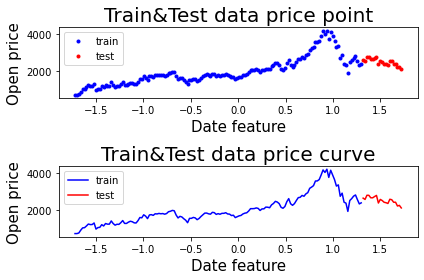

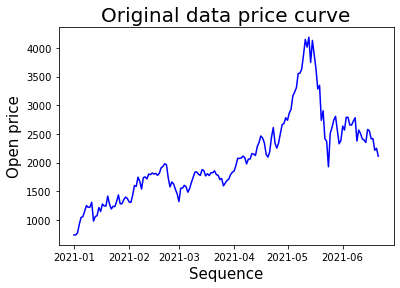

In [5]:
plt.subplot(211)
plt.plot(train_date_feature, train_open_price, '.', color="blue")
plt.plot(test_date_feature, test_open_price, '.', color="red")
plt.xlabel("Date feature", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Train&Test data price point", fontsize=20)
plt.legend(["train", "test"])

plt.subplot(212)
plt.plot(train_date_feature, train_open_price, color="blue")
plt.plot(test_date_feature, test_open_price, color="red")
plt.xlabel("Date feature", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Train&Test data price curve", fontsize=20)
plt.legend(["train", "test"])

plt.tight_layout()
plt.savefig(outdir_0 + r"Date feature.jpg")
plt.show()

plt.plot(eth_simple_df["open"], color="blue")
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Original data price curve", fontsize=20)

plt.savefig(outdir_0 + r"Original curve.jpg")
plt.show()


### Train model(Power of 1)

In [6]:
x_train = train_date_feature.copy()
y_train = train_open_price.copy()
n = len(x_train)
one = np.ones(n)
x_train = x_train.reshape(n, 1)
y_train = y_train.reshape(n, 1)

# Add 1 to the x_train let it can apply matrix multiplication with beta
x_train = np.concatenate((one.reshape(n, 1), x_train), axis=1)

# Initialize the weights and intercepts
beta = np.random.randn(2, 1)
MSE_beta = beta

# Initialize the iteration and learning_rate of MSE
iteration_of_MSE = 40
MSE_learning_rate = 0.1


[[19:57:52] INFO     <ipython-input-7-812a321e3619>:Line 18 ] Train Iteration: 10          Loss: 285981.823190 
[[19:57:52] INFO     <ipython-input-7-812a321e3619>:Line 18 ] Train Iteration: 20          Loss: 161879.006726 
[[19:57:52] INFO     <ipython-input-7-812a321e3619>:Line 18 ] Train Iteration: 30          Loss: 155735.765041 
[[19:57:52] INFO     <ipython-input-7-812a321e3619>:Line 18 ] Train Iteration: 40          Loss: 155404.535153 


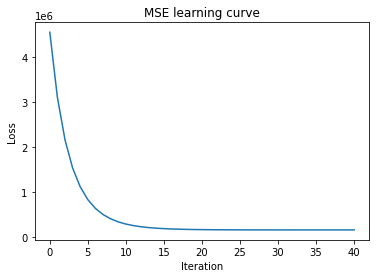

In [7]:
# Initialize the value for plot
MSE_iteration = np.zeros(1)
predict = x_train.dot(MSE_beta)
MSE_loss = (1/n) * sum((y_train-predict)**2)

# Training with using MSE as the objective function
for i in range(iteration_of_MSE):
    # Calculate gradients and update weight
    MSE_beta = MSE_beta - MSE_learning_rate \
                    * (2/n) \
                    * (((-x_train).T).dot(y_train-predict))
    # Predict the result
    predict = x_train.dot(MSE_beta)
    # Store the information each iteration for plot
    MSE_iteration = np.append(MSE_iteration, (i+1))
    MSE_loss = np.append(MSE_loss, (1/n) * sum((y_train-predict)**2))
    if (i+1)%10 == 0:
        log.info("Train Iteration: %d          Loss: %f" % ((i+1), MSE_loss[-1]))

# Plot the learning curve of MSE
plt.plot(MSE_iteration, MSE_loss)
plt.title("MSE learning curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.savefig(outdir_1 + r"Learning Curve.jpg")
plt.show()


### Test the performance on the testing data

In [8]:
x_test = test_date_feature.copy()
y_test = test_open_price.copy()
m = len(x_test)
one = np.ones(m)
x_test = x_test.reshape(m, 1)
y_test = y_test.reshape(m, 1)
x_test = np.concatenate((one.reshape(m, 1), x_test), axis=1)

MSE_y_pred = x_test.dot(MSE_beta)
MSE = (1/m) * sum((y_test-MSE_y_pred)**2)
print("mean squre error by objective function(MSE): ", MSE)

mean squre error by objective function(MSE):  [615077.34439192]


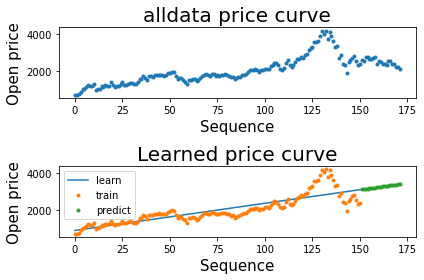

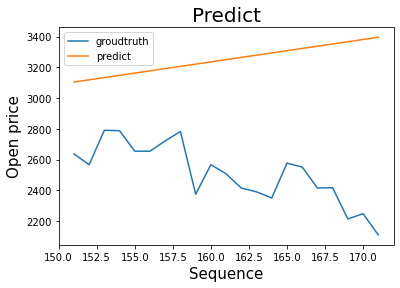

In [9]:
all_open_price = np.concatenate((train_open_price, test_open_price))
MSE_open_price = np.concatenate((train_open_price, MSE_y_pred.reshape(MSE_y_pred.shape[0])))

plt.subplot(211)
plt.plot(all_open_price, '.')
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("alldata price curve", fontsize=20)

plt.subplot(212)
#The curve that it learn
ytr = x_train.dot(MSE_beta)
y = np.concatenate((ytr, MSE_y_pred), axis=0)
plt.plot(y)

seq =  train_open_price.shape[0]
plt.plot(np.arange(seq), train_open_price, '.')
plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), MSE_y_pred.reshape(MSE_y_pred.shape[0]), '.')
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Learned price curve", fontsize=20)
plt.legend(["learn", "train", "predict"])

plt.tight_layout()
plt.savefig(outdir_1 + r"Learned curve.jpg")
plt.show()

plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), test_open_price)
plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), MSE_y_pred.reshape(MSE_y_pred.shape[0]))
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Predict", fontsize=20)
plt.legend(["groudtruth", "predict"])

plt.savefig(outdir_1 + r"Predict.jpg")
plt.show()

### Train model(Power of 1 to 7 with regularization)

In [10]:
x_train = train_date_feature.copy()
y_train = train_open_price.copy()
n = len(x_train)
one = np.ones(n)
x_train = x_train.reshape(n, 1)
y_train = y_train.reshape(n, 1)

# Add 1 to the x_train let it can apply matrix multiplication with beta
x_train = np.concatenate((one.reshape(n, 1), x_train), axis=1)

# Create high power feature
for i in range(6):
    temp_feature = train_eth_df["DateToNum"].to_numpy()
    temp_feature = temp_feature**(i+2) # New feature
    temp_feature = (temp_feature - np.mean(tmp_date_feature**(i+2))) / np.std(tmp_date_feature**(i+2)) # Standardization
    x_train = np.concatenate((x_train, (temp_feature).reshape(n, 1)), axis=1)

# Initialize the weights and intercepts
beta = np.random.randn(x_train.shape[1], 1)
MSE_beta = beta

# Initialize the iteration and learning_rate of MSE
iteration_of_MSE = 40
MSE_learning_rate = 0.1
reg_lamda = 0.1

[[19:57:54] INFO     <ipython-input-11-dfd37a222c37>:Line 21 ] Train Iteration: 10          Loss: 242987.904469 
[[19:57:54] INFO     <ipython-input-11-dfd37a222c37>:Line 21 ] Train Iteration: 20          Loss: 148196.206763 
[[19:57:54] INFO     <ipython-input-11-dfd37a222c37>:Line 21 ] Train Iteration: 30          Loss: 143872.819920 
[[19:57:54] INFO     <ipython-input-11-dfd37a222c37>:Line 21 ] Train Iteration: 40          Loss: 142470.597226 


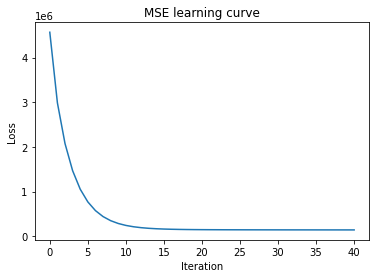

In [11]:
# Initialize the value for plot
MSE_iteration = np.zeros(1)
predict = x_train.dot(MSE_beta)
MSE_loss = (1/n) * (sum((y_train-predict)**2) + reg_lamda * sum(MSE_beta[1:]**2))

# Training with using MSE as the objective function
for i in range(iteration_of_MSE):
    # Calculate gradients and update weight
    MSE_beta[0] = MSE_beta[0] - MSE_learning_rate \
                    * (2/n) \
                    * ((((-x_train).T)[0]).dot(y_train-predict))
    MSE_beta[1:] = MSE_beta[1:]*(1 - 2*MSE_learning_rate*reg_lamda/n) - MSE_learning_rate \
                    * (2/n) \
                    * ((((-x_train).T)[1:]).dot(y_train-predict))
    # Predict the result
    predict = x_train.dot(MSE_beta)
    # Store the information each iteration for plot
    MSE_iteration = np.append(MSE_iteration, (i+1))
    MSE_loss = np.append(MSE_loss, (1/n) * (sum((y_train-predict)**2) + reg_lamda * sum(MSE_beta[1:]**2)))
    if (i+1)%10 == 0:
        log.info("Train Iteration: %d          Loss: %f" % ((i+1), MSE_loss[-1]))

# Plot the learning curve of MSE
plt.plot(MSE_iteration, MSE_loss)
plt.title("MSE learning curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.savefig(outdir_2 + r"Learning Curve.jpg")
plt.show()


### Test the performance on the testing data

In [12]:
x_test = test_date_feature.copy()
y_test = test_open_price.copy()
m = len(x_test)
one = np.ones(m)
x_test = x_test.reshape(m, 1)
y_test = y_test.reshape(m, 1)
x_test = np.concatenate((one.reshape(m, 1), x_test), axis=1)

# Create high power feature
for i in range(6):
    temp_feature = test_eth_df["DateToNum"].to_numpy()
    temp_feature = temp_feature**(i+2) # New feature
    temp_feature = (temp_feature - np.mean(tmp_date_feature**(i+2))) / np.std(tmp_date_feature**(i+2)) # Standardization
    x_test = np.concatenate((x_test, (temp_feature).reshape(m, 1)), axis=1)

MSE_y_pred = x_test.dot(MSE_beta)
MSE = (1/m) * sum((y_test-MSE_y_pred)**2)
print(MSE_beta)
print("mean squre error by objective function(MSE): ", MSE)

[[2098.24866289]
 [ 427.86459898]
 [ 346.34937437]
 [ 228.38256684]
 [  87.77080493]
 [ -51.00015493]
 [-177.93761306]
 [-284.70400436]]
mean squre error by objective function(MSE):  [117926.21274045]


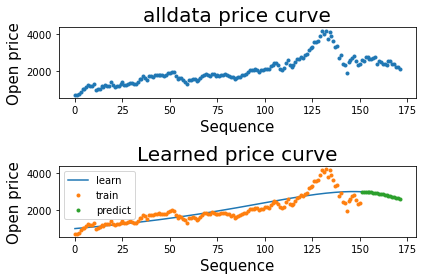

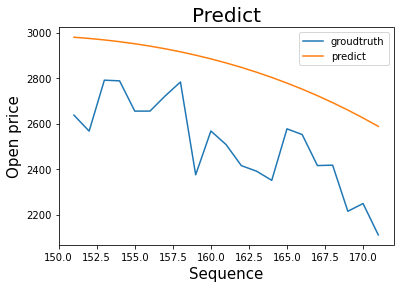

In [13]:
all_open_price = np.concatenate((train_open_price, test_open_price))
MSE_open_price = np.concatenate((train_open_price, MSE_y_pred.reshape(MSE_y_pred.shape[0])))

plt.subplot(211)
plt.plot(all_open_price, '.')
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("alldata price curve", fontsize=20)

plt.subplot(212)
#The curve that it learn
ytr = x_train.dot(MSE_beta)
y = np.concatenate((ytr, MSE_y_pred), axis=0)
plt.plot(y)

seq =  train_open_price.shape[0]
plt.plot(np.arange(seq), train_open_price, '.')
plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), MSE_y_pred.reshape(MSE_y_pred.shape[0]), '.')
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Learned price curve", fontsize=20)
plt.legend(["learn", "train", "predict"])

plt.tight_layout()
plt.savefig(outdir_2 + r"Learned curve.jpg")
plt.show()

plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), test_open_price)
plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), MSE_y_pred.reshape(MSE_y_pred.shape[0]))
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Predict", fontsize=20)
plt.legend(["groudtruth", "predict"])

plt.savefig(outdir_2 + r"Predict.jpg")
plt.show()

## Linear regression with feature that I create----------------------------------------------------------------------

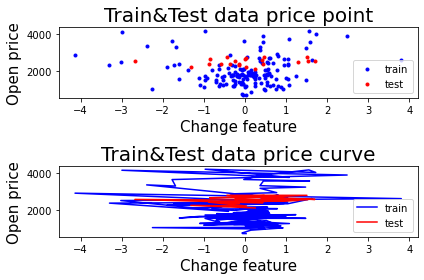

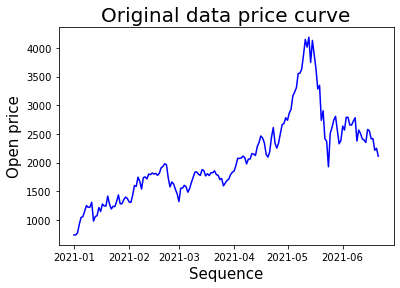

In [14]:
plt.subplot(211)
plt.plot(train_change, train_open_price, '.', color="blue")
plt.plot(test_change, test_open_price, '.', color="red")
plt.xlabel("Change feature", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Train&Test data price point", fontsize=20)
plt.legend(["train", "test"])

plt.subplot(212)
plt.plot(train_change, train_open_price, color="blue")
plt.plot(test_change, test_open_price, color="red")
plt.xlabel("Change feature", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Train&Test data price curve", fontsize=20)
plt.legend(["train", "test"])

plt.tight_layout()
plt.savefig(outdir_0 + r"Change Feature.jpg")
plt.show()

plt.plot(eth_simple_df["open"], color="blue")
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Original data price curve", fontsize=20)

plt.savefig(outdir_0 + r"Original Curve.jpg")
plt.show()


### Train model(Power of 1 to 7 with regularization)

In [15]:
x_train = train_change.copy()
y_train = train_open_price.copy()
n = len(x_train)
one = np.ones(n)
x_train = x_train.reshape(n, 1)
y_train = y_train.reshape(n, 1)

# Add 1 to the x_train let it can apply matrix multiplication with beta
x_train = np.concatenate((one.reshape(n, 1), x_train), axis=1)

# Create high power feature
for i in range(6):
    temp_feature = train_eth_df["Change"].to_numpy()
    temp_feature = temp_feature**(i+2) # New feature
    temp_feature = (temp_feature - np.mean(temp_feature)) / np.std(temp_feature) # Standardization
    x_train = np.concatenate((x_train, (temp_feature).reshape(n, 1)), axis=1)

# Initialize the weights and intercepts
beta = np.random.randn(x_train.shape[1], 1)
MSE_beta = beta

# Initialize the iteration and learning_rate of MSE
iteration_of_MSE = 40
MSE_learning_rate = 0.1
reg_lamda = 1

[[19:57:55] INFO     <ipython-input-16-3e86553d828c>:Line 21 ] Train Iteration: 10          Loss: 528862.673430 
[[19:57:56] INFO     <ipython-input-16-3e86553d828c>:Line 21 ] Train Iteration: 20          Loss: 461379.787206 
[[19:57:56] INFO     <ipython-input-16-3e86553d828c>:Line 21 ] Train Iteration: 30          Loss: 448890.698489 
[[19:57:56] INFO     <ipython-input-16-3e86553d828c>:Line 21 ] Train Iteration: 40          Loss: 442197.595055 


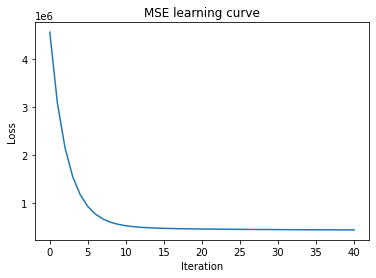

In [16]:
# Initialize the value for plot
MSE_iteration = np.zeros(1)
predict = x_train.dot(MSE_beta)
MSE_loss = (1/n) * (sum((y_train-predict)**2) + reg_lamda * sum(MSE_beta[1:]**2))

# Training with using MSE as the objective function
for i in range(iteration_of_MSE):
    # Calculate gradients and update weight
    MSE_beta[0] = MSE_beta[0] - MSE_learning_rate \
                    * (2/n) \
                    * ((((-x_train).T)[0]).dot(y_train-predict))
    MSE_beta[1:] = MSE_beta[1:]*(1 - 2*MSE_learning_rate*reg_lamda/n) - MSE_learning_rate \
                    * (2/n) \
                    * ((((-x_train).T)[1:]).dot(y_train-predict))
    # Predict the result
    predict = x_train.dot(MSE_beta)
    # Store the information each iteration for plot
    MSE_iteration = np.append(MSE_iteration, (i+1))
    MSE_loss = np.append(MSE_loss, (1/n) * (sum((y_train-predict)**2) + reg_lamda * sum(MSE_beta[1:]**2)))
    if (i+1)%10 == 0:
        log.info("Train Iteration: %d          Loss: %f" % ((i+1), MSE_loss[-1]))

# Plot the learning curve of MSE
plt.plot(MSE_iteration, MSE_loss)
plt.title("MSE learning curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.savefig(outdir_3 + r"Learning Curve.jpg")
plt.show()


### Test the performance on the testing data

In [17]:
x_test = test_change.copy()
y_test = test_open_price.copy()
m = len(x_test)
one = np.ones(m)
x_test = x_test.reshape(m, 1)
y_test = y_test.reshape(m, 1)
x_test = np.concatenate((one.reshape(m, 1), x_test), axis=1)

# Create high power feature
for i in range(6):
    temp_feature = test_eth_df["Change"].to_numpy()
    temp_feature = temp_feature**(i+2) # New feature
    temp_feature = (temp_feature - np.mean(temp_feature)) / np.std(temp_feature) # Standardization
    x_test = np.concatenate((x_test, (temp_feature).reshape(m, 1)), axis=1)

MSE_y_pred = x_test.dot(MSE_beta)
MSE = (1/m) * sum((y_test-MSE_y_pred)**2)
print(MSE_beta)
print("mean squre error by objective function(MSE): ", MSE)

[[1999.61063609]
 [ 155.13014358]
 [ 482.14925068]
 [ -14.82468374]
 [ -43.55914498]
 [ -46.76735402]
 [-220.84003923]
 [ -34.71041849]]
mean squre error by objective function(MSE):  [385409.92735766]


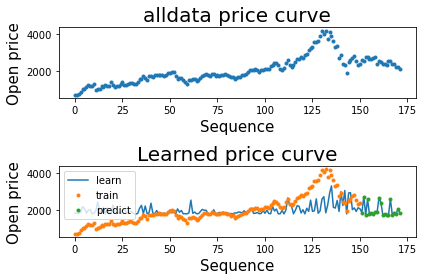

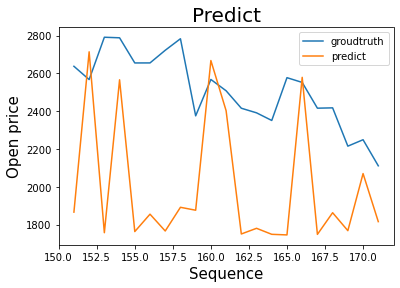

In [18]:
all_open_price = np.concatenate((train_open_price, test_open_price))
MSE_open_price = np.concatenate((train_open_price, MSE_y_pred.reshape(MSE_y_pred.shape[0])))

plt.subplot(211)
plt.plot(all_open_price, '.')
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("alldata price curve", fontsize=20)

plt.subplot(212)
#The curve that it learn
ytr = x_train.dot(MSE_beta)
y = np.concatenate((ytr, MSE_y_pred), axis=0)
plt.plot(y)

seq =  train_open_price.shape[0]
plt.plot(np.arange(seq), train_open_price, '.')
plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), MSE_y_pred.reshape(MSE_y_pred.shape[0]), '.')
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Learned price curve", fontsize=20)
plt.legend(["learn", "train", "predict"])

plt.tight_layout()
plt.savefig(outdir_3 + r"Learned curve.jpg")
plt.show()

plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), test_open_price)
plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), MSE_y_pred.reshape(MSE_y_pred.shape[0]))
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Predict", fontsize=20)
plt.legend(["groudtruth", "predict"])


plt.savefig(outdir_3 + r"Predict.jpg")
plt.show()

### Train model(Power of 1 to 7 with regularization with 2 features)

In [19]:
x_train = train_change.copy()
y_train = train_open_price.copy()
n = len(x_train)
one = np.ones(n)
x_train = x_train.reshape(n, 1)
y_train = y_train.reshape(n, 1)

# Add 1 to the x_train let it can apply matrix multiplication with beta
x_train = np.concatenate((one.reshape(n, 1), x_train), axis=1)
x_train = np.concatenate((x_train, (train_date_feature.copy()).reshape(n,1)), axis=1)

temp_feature1 = train_eth_df["Change"].to_numpy()
temp_feature2 = train_eth_df["DateToNum"].to_numpy()
temp_feature = temp_feature1*temp_feature2
temp_feature = (temp_feature - np.mean(temp_feature)) / np.std(temp_feature) # Standardization
x_train = np.concatenate((x_train, (temp_feature).reshape(n, 1)), axis=1)

# Create high power feature
for i in range(6):
    temp_feature1 = train_eth_df["Change"].to_numpy()
    temp_feature2 = train_eth_df["DateToNum"].to_numpy()
    temp_feature = temp_feature1*temp_feature2
    
    temp_feature1 = temp_feature1**(i+2) # New feature
    temp_feature2 = temp_feature2**(i+2) # New feature
    temp_feature = temp_feature**(i+2) # New feature
    
    temp_feature1 = (temp_feature1 - np.mean(temp_feature1)) / np.std(temp_feature1) # Standardization
    temp_feature2 = (temp_feature2 - np.mean(tmp_date_feature**(i+2))) / np.std(tmp_date_feature**(i+2)) # Standardization
    temp_feature = (temp_feature - np.mean(temp_feature)) / np.std(temp_feature) # Standardization
    
    x_train = np.concatenate((x_train, (temp_feature1).reshape(n, 1)), axis=1)
    x_train = np.concatenate((x_train, (temp_feature2).reshape(n, 1)), axis=1)
    x_train = np.concatenate((x_train, (temp_feature).reshape(n, 1)), axis=1)

# Initialize the weights and intercepts
beta = np.random.randn(x_train.shape[1], 1)
MSE_beta = beta

# Initialize the iteration and learning_rate of MSE
iteration_of_MSE = 40
MSE_learning_rate = 0.1
reg_lamda = 1

[[19:57:57] INFO     <ipython-input-20-1e1628d120b3>:Line 21 ] Train Iteration: 10          Loss: 226318.122268 
[[19:57:57] INFO     <ipython-input-20-1e1628d120b3>:Line 21 ] Train Iteration: 20          Loss: 129155.638366 
[[19:57:57] INFO     <ipython-input-20-1e1628d120b3>:Line 21 ] Train Iteration: 30          Loss: 123740.009006 
[[19:57:57] INFO     <ipython-input-20-1e1628d120b3>:Line 21 ] Train Iteration: 40          Loss: 121692.655421 


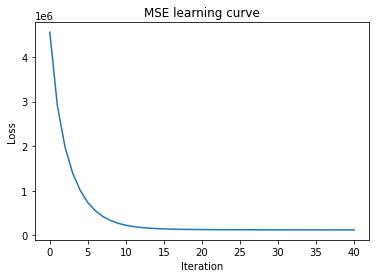

In [20]:
# Initialize the value for plot
MSE_iteration = np.zeros(1)
predict = x_train.dot(MSE_beta)
MSE_loss = (1/n) * (sum((y_train-predict)**2) + reg_lamda * sum(MSE_beta[1:]**2))

# Training with using MSE as the objective function
for i in range(iteration_of_MSE):
    # Calculate gradients and update weight
    MSE_beta[0] = MSE_beta[0] - MSE_learning_rate \
                    * (2/n) \
                    * ((((-x_train).T)[0]).dot(y_train-predict))
    MSE_beta[1:] = MSE_beta[1:]*(1 - 2*MSE_learning_rate*reg_lamda/n) - MSE_learning_rate \
                    * (2/n) \
                    * ((((-x_train).T)[1:]).dot(y_train-predict))
    # Predict the result
    predict = x_train.dot(MSE_beta)
    # Store the information each iteration for plot
    MSE_iteration = np.append(MSE_iteration, (i+1))
    MSE_loss = np.append(MSE_loss, (1/n) * (sum((y_train-predict)**2) + reg_lamda * sum(MSE_beta[1:]**2)))
    if (i+1)%10 == 0:
        log.info("Train Iteration: %d          Loss: %f" % ((i+1), MSE_loss[-1]))

# Plot the learning curve of MSE
plt.plot(MSE_iteration, MSE_loss)
plt.title("MSE learning curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.savefig(outdir_4 + r"Learning Curve.jpg")
plt.show()


### Test the performance on the testing data

In [21]:
x_test = test_change.copy()
y_test = test_open_price.copy()
m = len(x_test)
one = np.ones(m)
x_test = x_test.reshape(m, 1)
y_test = y_test.reshape(m, 1)

x_test = np.concatenate((one.reshape(m, 1), x_test), axis=1)
x_test = np.concatenate((x_test, (test_date_feature.copy()).reshape(m,1)), axis=1)

temp_feature1 = test_eth_df["Change"].to_numpy()
temp_feature2 = test_eth_df["DateToNum"].to_numpy()
temp_feature = temp_feature1*temp_feature2
temp_feature = (temp_feature - np.mean(temp_feature)) / np.std(temp_feature) # Standardization
x_test = np.concatenate((x_test, (temp_feature).reshape(m, 1)), axis=1)

# Create high power feature
for i in range(6):
    temp_feature1 = test_eth_df["Change"].to_numpy()
    temp_feature2 = test_eth_df["DateToNum"].to_numpy()
    temp_feature = temp_feature1*temp_feature2
    
    temp_feature1 = temp_feature1**(i+2) # New feature
    temp_feature2 = temp_feature2**(i+2) # New feature
    temp_feature = temp_feature**(i+2) # New feature
    
    temp_feature1 = (temp_feature1 - np.mean(temp_feature1)) / np.std(temp_feature1) # Standardization
    temp_feature2 = (temp_feature2 - np.mean(tmp_date_feature**(i+2))) / np.std(tmp_date_feature**(i+2)) # Standardization
    temp_feature = (temp_feature - np.mean(temp_feature)) / np.std(temp_feature) # Standardization
    
    x_test = np.concatenate((x_test, (temp_feature1).reshape(m, 1)), axis=1)
    x_test = np.concatenate((x_test, (temp_feature2).reshape(m, 1)), axis=1)
    x_test = np.concatenate((x_test, (temp_feature).reshape(m, 1)), axis=1)
    

MSE_y_pred = x_test.dot(MSE_beta)
MSE = (1/m) * sum((y_test-MSE_y_pred)**2)
print(MSE_beta)
print("mean squre error by objective function(MSE): ", MSE)

[[2060.72559073]
 [  50.68577766]
 [ 426.78885541]
 [ 111.10441489]
 [ 153.92450061]
 [ 315.65612598]
 [ 218.78393971]
 [   4.9289779 ]
 [ 190.76344724]
 [   7.86287059]
 [ -37.8214561 ]
 [  58.16666678]
 [ -71.76738619]
 [ -25.59910013]
 [ -70.86297481]
 [ -16.74950095]
 [ -85.99287738]
 [-184.83633789]
 [-125.89887508]
 [ -39.58495586]
 [-282.50301628]
 [ -34.11076771]]
mean squre error by objective function(MSE):  [70776.09644127]


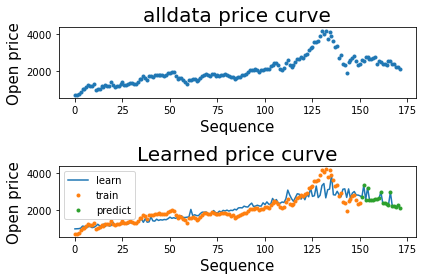

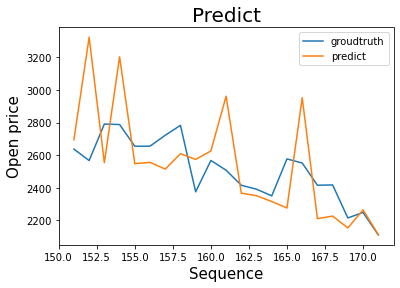

In [22]:
all_open_price = np.concatenate((train_open_price, test_open_price))
MSE_open_price = np.concatenate((train_open_price, MSE_y_pred.reshape(MSE_y_pred.shape[0])))

plt.subplot(211)
plt.plot(all_open_price, '.')
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("alldata price curve", fontsize=20)

plt.subplot(212)
#The curve that it learn
ytr = x_train.dot(MSE_beta)
y = np.concatenate((ytr, MSE_y_pred), axis=0)
plt.plot(y)

seq =  train_open_price.shape[0]
plt.plot(np.arange(seq), train_open_price, '.')
plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), MSE_y_pred.reshape(MSE_y_pred.shape[0]), '.')
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Learned price curve", fontsize=20)
plt.legend(["learn", "train", "predict"])

plt.tight_layout()
plt.savefig(outdir_4 + r"Learned curve.jpg")
plt.show()

plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), test_open_price)
plt.plot(np.arange(seq, seq + MSE_y_pred.shape[0]), MSE_y_pred.reshape(MSE_y_pred.shape[0]))
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("Predict", fontsize=20)
plt.legend(["groudtruth", "predict"])


plt.savefig(outdir_4 + r"Predict.jpg")
plt.show()

## Find the trend of the ethereum price-------------------------------------------------------------------------------

In [23]:
print("Please choose a start date to fit a trend of the ehereum\n", \
      "Using Example(Days):   2021-04-30\n", \
      "Using Example(Months): 2021-04\n", \
      "Using Example(Years):  2021\n")
split_date = input("Start Date: ")
data_fit = eth_url_df[split_date:]

# Data Standardization & Create sequence feature
trend_open_price = data_fit["open"].to_numpy()
trend_seq_feature = np.arange(trend_open_price.shape[0])
trend_seq_feature = (trend_seq_feature - np.mean(trend_seq_feature)) / np.std(trend_seq_feature) # Standardization

Please choose a start date to fit a trend of the ehereum
 Using Example(Days):   2021-04-30
 Using Example(Months): 2021-04
 Using Example(Years):  2021

Start Date: 2021-06-15


### Train model to find trend of ethereum

In [24]:
x_train = trend_seq_feature.copy()
y_train = trend_open_price.copy()
n = len(x_train)
one = np.ones(n)
x_train = x_train.reshape(n, 1)
y_train = y_train.reshape(n, 1)

# Add 1 to the x_train let it can apply matrix multiplication with beta
x_train = np.concatenate((one.reshape(n, 1), x_train), axis=1)

# Initialize the weights and intercepts
beta = np.random.randn(2, 1)
MSE_beta = beta

# Initialize the iteration and learning_rate of MSE
iteration_of_MSE = 40
MSE_learning_rate = 0.1


[[19:58:06] INFO     <ipython-input-25-ec8170bac8f9>:Line 18 ] Train Iteration: 10          Loss: 66559.484769 
[[19:58:06] INFO     <ipython-input-25-ec8170bac8f9>:Line 18 ] Train Iteration: 20          Loss: 3260.115780 
[[19:58:06] INFO     <ipython-input-25-ec8170bac8f9>:Line 18 ] Train Iteration: 30          Loss: 2530.323743 
[[19:58:06] INFO     <ipython-input-25-ec8170bac8f9>:Line 18 ] Train Iteration: 40          Loss: 2521.909814 


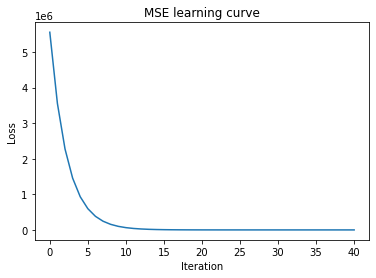

[[2350.46432914]
 [-154.83418183]]


In [25]:
# Initialize the value for plot
MSE_iteration = np.zeros(1)
predict = x_train.dot(MSE_beta)
MSE_loss = (1/n) * sum((y_train-predict)**2)

# Training with using MSE as the objective function
for i in range(iteration_of_MSE):
    # Calculate gradients and update weight
    MSE_beta = MSE_beta - MSE_learning_rate \
                    * (2/n) \
                    * (((-x_train).T).dot(y_train-predict))
    # Predict the result
    predict = x_train.dot(MSE_beta)
    # Store the information each iteration for plot
    MSE_iteration = np.append(MSE_iteration, (i+1))
    MSE_loss = np.append(MSE_loss, (1/n) * sum((y_train-predict)**2))
    if (i+1)%10 == 0:
        log.info("Train Iteration: %d          Loss: %f" % ((i+1), MSE_loss[-1]))

# Plot the learning curve of MSE
plt.plot(MSE_iteration, MSE_loss)
plt.title("MSE learning curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.savefig(outdir_5 + r"Learning Curve.jpg")
plt.show()

print(MSE_beta)

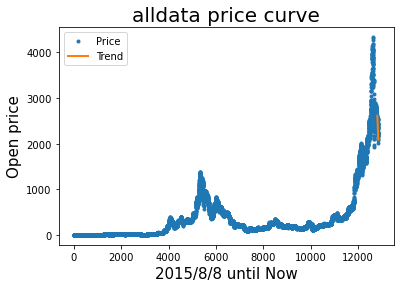

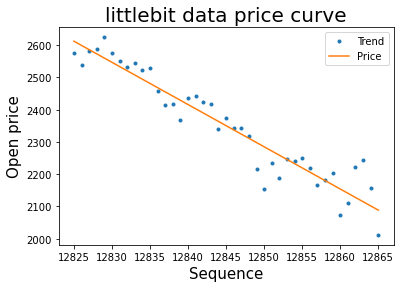

In [26]:
# Overall
MSE_y_pred = x_train.dot(MSE_beta)
all_open_price = eth_url_df["open"].to_numpy()

seq = all_open_price.shape[0]

plt.plot(np.arange(seq), all_open_price, '.')
plt.plot(np.arange(seq - MSE_y_pred.shape[0], seq), MSE_y_pred.reshape(MSE_y_pred.shape[0]), linewidth="2")
plt.xlabel("2015/8/8 until Now", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("alldata price curve", fontsize=20)
plt.legend(["Price", "Trend"])

plt.savefig(outdir_5 + r"Trend in full data.jpg")
plt.show()

# A littlebit part
all_open_price = eth_url_df["open"].to_numpy()

seq = all_open_price.shape[0]

# plt.plot(np.arange(seq - MSE_y_pred.shape[0] - 30, seq), all_open_price[(seq - MSE_y_pred.shape[0] - 30):seq], '.')
plt.plot(np.arange(seq - MSE_y_pred.shape[0], seq), all_open_price[(seq - MSE_y_pred.shape[0]):seq], '.')
plt.plot(np.arange(seq - MSE_y_pred.shape[0], seq), MSE_y_pred.reshape(MSE_y_pred.shape[0]))
plt.xlabel("Sequence", fontsize=15)
plt.ylabel("Open price", fontsize=15)
plt.title("littlebit data price curve", fontsize=20)
plt.legend(["Trend", "Price"])

plt.savefig(outdir_5 + r"Trend.jpg")
plt.show()